In [1]:
import os
import re
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

os.environ['CUDA_VISIBLE_DEVICES']='1'

2023-11-22 08:48:38.358352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 08:48:38.443309: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Signal region and sideband region 

In [2]:
def get_info(path):
    # path: run path
    name = os.path.split(path)[1]

    with open(os.path.join(path, f'{name}_tag_1_banner.txt')) as f:
        for line in f.readlines():
                
            #  Integrated weight (pb)  :       0.020257
            match = re.match('#  Integrated weight \(pb\)  : +(\d+\.\d+)', line)
            if match:
                # unit: fb
                cross_section = float(match.group(1)) * 1000
            # #  Number of Events        :       100000
            match = re.match('#  Number of Events        :       (\d+)', line)
            if match:
                # unit: fb
                nevent = int(match.group(1))
    
    return cross_section, nevent

In [3]:
def DeltaR(eta1, phi1, eta2, phi2):
    dEta = eta1 - eta2
    dPhi = np.abs(phi1 - phi2)
    dPhi = np.where(dPhi > np.pi, 2 * np.pi - dPhi, dPhi)
    return np.sqrt(dEta ** 2 + dPhi ** 2)

def FourMomentum(pt, eta, phi, m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return e, px, py, pz

def PtEtaPhiM(px, py, pz, e):
    E, px, py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(E**2 - px**2 - py**2 - pz**2)

    return pt, eta, phi, m
    
def InvM(e, px, py, pz):
    return np.sqrt(np.sum(e)**2 - np.sum(px)**2 - np.sum(py)**2 - np.sum(pz)**2)

def Mjets(*arg):
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

In [4]:
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest      

In [5]:
def min_dR_pairing(PT, Eta, Phi, Mass):
    # 假設 PT, Eta, Phi, Mass 的形狀為 (n_events, 4)
    
    # 生成所有可能的配對 (n_pairs, 4)
    pairs = np.array(list(all_pairs([0, 1, 2, 3]))).reshape(-1, 4)

    # PT shape: (n_events, 4) -> (n_events, 1, 4), pairs shape: (n_pairs, 4) -> (1, n_pairs, 4)
    # output array shape: (n_events, n_pairs, 4)
    PT_pairs = np.take_along_axis(PT[:, None, :], pairs[None, :, :], axis=2)
    Eta_pairs = np.take_along_axis(Eta[:, None, :], pairs[None, :, :], axis=2)
    Phi_pairs = np.take_along_axis(Phi[:, None, :], pairs[None, :, :], axis=2)
    Mass_pairs = np.take_along_axis(Mass[:, None, :], pairs[None, :, :], axis=2)

    # e1 shape: (n_events, n_pairs, 2)
    # PTH1 shape: (n_events, n_pairs)
    e1, px1, py1, pz1 = FourMomentum(PT_pairs[..., :2], Eta_pairs[..., :2], Phi_pairs[..., :2], Mass_pairs[..., :2])
    PTH1, _, _, _ = PtEtaPhiM(np.sum(px1, axis=2), np.sum(py1, axis=2), np.sum(pz1, axis=2), np.sum(e1, axis=2))

    e2, px2, py2, pz2 = FourMomentum(PT_pairs[..., 2:], Eta_pairs[..., 2:], Phi_pairs[..., 2:], Mass_pairs[..., 2:])
    PTH2, _, _, _ = PtEtaPhiM(np.sum(px2, axis=2), np.sum(py2, axis=2), np.sum(pz2, axis=2), np.sum(e2, axis=2))
    
    # possible_pairs shape: (2, n_pairs, 4) -> (1, 2, n_pairs, 4)
    # greater_PT shape: (n_events, n_pairs) -> (n_events, 1, n_pairs, 1)  
    # indices shape: (n_events, 1, n_pairs, 4) -> (n_events, n_pairs, 4)
    possible_pairs = np.array([pairs, pairs[:,[2,3,0,1]]])
    greater_PT = np.where(PTH1 > PTH2, 0, 1)
    indices = np.take_along_axis(possible_pairs[None, ...] , greater_PT[:,None, :, None] , axis=1)[:,0,:,:]

    # Eta1, Phi1 shape: (n_events, n_pairs, 2)
    Eta1 = np.take_along_axis(Eta[:, None, :], indices[:,:,[0,1]], axis=2)
    Phi1 = np.take_along_axis(Phi[:, None, :], indices[:,:,[0,1]], axis=2)

    # dR shape: (n_events, n_pairs)
    dR = DeltaR(Eta1[:,:,0], Phi1[:,:,0], Eta1[:,:,1], Phi1[:,:,1])

    # 找到每個事件的最小 dR (n_events,)
    min_dR_indices = np.argmin(dR, axis=1)

    # output array shape: (n_events, 1, 4)
    # 返回最小 dR 的配對 (n_events, 4)
    return np.take_along_axis(indices, min_dR_indices[:, None, None], axis=1)[:,0,:]

In [6]:
def diHiggs_selection(file_path, tot_event, pairing_method, xection=None, SRSB_region=[[800, 1050], [700, 1100]]):
    # file_path: h5 file path
    # tot_event: total event number
    
    cross_section = xection

    # signal and sideband range
    SR_range = SRSB_region[0]
    SB_range = SRSB_region[1]

    with h5py.File(file_path, 'r') as f:
        nevent = f['INPUTS/Source/pt'].shape[0]
        
        jet_PT = f['INPUTS/Source/pt'][...]
        jet_Eta = f['INPUTS/Source/eta'][...]
        jet_Phi = f['INPUTS/Source/phi'][...]
        jet_Mass = f['INPUTS/Source/mass'][...]
        jet_BTag = f['INPUTS/Source/btag'][...]

    # |eta| < 2.5 & PT > 40 GeV & b-tagged
    eta_pt_bTag_cut = ((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))

    if pairing_method == 'min_dR':
        # choose 4 highest pt b-jets
        h_jets = np.array([np.where(row)[0][:4] for row in eta_pt_bTag_cut])

        PT = np.take_along_axis(jet_PT, h_jets, axis=1)
        Eta = np.take_along_axis(jet_Eta, h_jets, axis=1)
        Phi = np.take_along_axis(jet_Phi, h_jets, axis=1)
        Mass = np.take_along_axis(jet_Mass, h_jets, axis=1)
        h_candidate = min_dR_pairing(PT, Eta, Phi, Mass)
    else:
        print('Wrong pairing method!')
        return

    # Total invariant mass: mhh
    e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
    _, _, _, m4j = PtEtaPhiM(np.sum(px, axis=1), np.sum(py, axis=1), np.sum(pz, axis=1), np.sum(e, axis=1))

    # Get Higgs candidates information
    i1i2, i3i4 = h_candidate[:,[0,1]], h_candidate[:,[2,3]]

    PT1 = np.take_along_axis(PT, i1i2, axis=1)
    Eta1 = np.take_along_axis(Eta, i1i2, axis=1)
    Phi1 = np.take_along_axis(Phi, i1i2, axis=1)
    Mass1 = np.take_along_axis(Mass, i1i2, axis=1)

    e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
    _, _, _, MassH1 = PtEtaPhiM(np.sum(px1, axis=1), np.sum(py1, axis=1), np.sum(pz1, axis=1), np.sum(e1, axis=1))

    PT2 = np.take_along_axis(PT, i3i4, axis=1)
    Eta2 = np.take_along_axis(Eta, i3i4, axis=1)
    Phi2 = np.take_along_axis(Phi, i3i4, axis=1)
    Mass2 = np.take_along_axis(Mass, i3i4, axis=1)

    e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
    _, _, _, MassH2 = PtEtaPhiM(np.sum(px2, axis=1), np.sum(py2, axis=1), np.sum(pz2, axis=1), np.sum(e2, axis=1))
            
    SR_count = ((SR_range[0] < m4j) & (m4j < SR_range[1])).sum()
    SB_count = (((SB_range[0] < m4j) & (m4j < SR_range[0])) | ((SR_range[1] < m4j) & (m4j < SB_range[1]))).sum()

    # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
    cross_section_abs = cross_section * nevent / tot_event

    cutflow_count = {
        'nevent': tot_event,
        'Cross section': cross_section,
        'Four tag': nevent,
        'Signal region': SR_count,
        'Sideband region': SB_count,
    }
        
    cutflow_cross_section = {
        'nevent': nevent,
        'Cross section': cross_section,
        'Four tag': cross_section_abs,
        'Signal region': cross_section_abs * SR_count / nevent,
        'Sideband region': cross_section_abs * SB_count / nevent,
    }

    results = {
        'cutflow count': cutflow_count,
        'cutflow cross section':cutflow_cross_section,
        'mh': np.array([MassH1, MassH2]),
        'mhh': m4j,
    }

    return results

## 1000 GeV

In [7]:
# Signal: 1000 GeV resonant
SRSB_region = [[800, 1050], [700, 1100]]

run_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/run_01'
h5_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/h5_data/DiHiggs_4b_PT40.h5'

xection, tot_event = get_info(run_path)
pairing_method = 'min_dR'

results_s = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              SRSB_region
                              )

# Background
run_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/MG5/resonant/pp4b_2525/Events/run_01'
h5_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/resonant/pp4b_2525/1M_diHiggs_4b_PT40-01.h5'

xection, tot_event = get_info(run_path)
pairing_method = 'min_dR'

results_b = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              SRSB_region
                              )

In [8]:
print(results_s['cutflow cross section'])
print(results_b['cutflow cross section'])

{'nevent': 12234, 'Cross section': 0.66007, 'Four tag': 0.08075296380000001, 'Signal region': 0.06310929270000001, 'Sideband region': 0.009650223400000001}
{'nevent': 9571, 'Cross section': 630389.756, 'Four tag': 6033.460354676001, 'Signal region': 332.21540141200006, 'Sideband region': 318.97721653600007}


In [9]:
L = 78
n_SR_s = results_s['cutflow cross section']['Signal region'] * L
n_SB_s = results_s['cutflow cross section']['Sideband region'] * L

n_SR_b = results_b['cutflow cross section']['Signal region'] * L
n_SB_b = results_b['cutflow cross section']['Sideband region'] * L

print(f'Signal region:   s = {n_SR_s:3.1f}, b = {n_SR_b:.1f}')
print(f'Sideband region: s = {n_SB_s:3.1f}, b = {n_SB_b:.1f}')

Signal region:   s = 4.9, b = 25912.8
Sideband region: s = 0.8, b = 24880.2


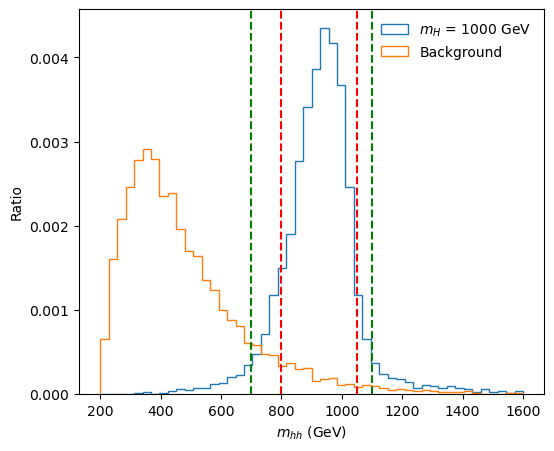

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6, 5))

ax.hist(results_s['mhh'], range=(200,1600), bins=50, histtype='step', density=True, label='$m_{H}$ = 1000 GeV')
ax.hist(results_b['mhh'], range=(200,1600), bins=50, histtype='step', density=True, label='Background')

# 指定要繪製垂直線的x座標
x_SR = [800,1050]
x_SB = [700,1100]
# 使用axvline函數繪製垂直線
ax.axvline(x=x_SR[0], color='r', linestyle='--')
ax.axvline(x=x_SR[1], color='r', linestyle='--')

ax.axvline(x=x_SB[0], color='g', linestyle='--')
ax.axvline(x=x_SB[1], color='g', linestyle='--')

ax.set_xlabel('$m_{hh}$ (GeV)')
ax.set_ylabel('Ratio')

ax.legend(frameon=False)
plt.savefig('./figures/mhh_distribution-1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

In [11]:
L = 139
ns = results_s['cutflow cross section']['Signal region'] * L
nb = results_b['cutflow cross section']['Signal region'] * L

print(f'S/B: {ns/nb:.2e}, S/sqrt(B): {ns/nb**0.5:.4f}')

S/B: 1.90e-04, S/sqrt(B): 0.0408


## 500 GeV

In [12]:
# Signal: 500 GeV resonant
SRSB_region = [[350, 550], [250, 700]]
run_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_500GeV/Events/run_01'
h5_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_500GeV/Events/h5_data/DiHiggs_4b_PT40.h5'

xection, tot_event = get_info(run_path)
pairing_method = 'min_dR'

results_s = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              SRSB_region,
                              )

# Background
run_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/MG5/resonant/pp4b_2525/Events/run_01'
h5_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/resonant/pp4b_2525/1M_diHiggs_4b_PT40-01.h5'

xection, tot_event = get_info(run_path)
pairing_method = 'min_dR'

results_b = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              SRSB_region,
                              )

In [13]:
print(results_s['cutflow cross section'])
print(results_b['cutflow cross section'])

{'nevent': 13520, 'Cross section': 26.929000000000002, 'Four tag': 3.6408008, 'Signal region': 3.1256490300000004, 'Sideband region': 0.35384706}
{'nevent': 9571, 'Cross section': 630389.756, 'Four tag': 6033.460354676001, 'Signal region': 2566.3166966760004, 'Sideband region': 2359.548856708}


In [14]:
L = 78
n_SR_s = results_s['cutflow cross section']['Signal region'] * L
n_SB_s = results_s['cutflow cross section']['Sideband region'] * L

n_SR_b = results_b['cutflow cross section']['Signal region'] * L
n_SB_b = results_b['cutflow cross section']['Sideband region'] * L

print(f'Signal region:   s = {n_SR_s:5.1f}, b = {n_SR_b:.1f}')
print(f'Sideband region: s = {n_SB_s:5.1f}, b = {n_SB_b:.1f}')

Signal region:   s = 243.8, b = 200172.7
Sideband region: s =  27.6, b = 184044.8


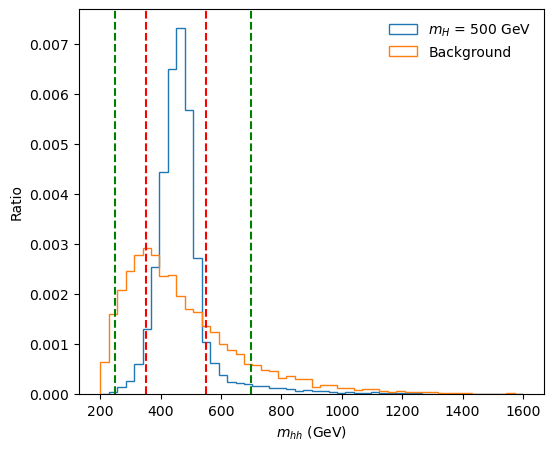

In [15]:
fig, ax = plt.subplots(1,1,figsize=(6, 5))

ax.hist(results_s['mhh'], range=(200,1600), bins=50, histtype='step', density=True, label='$m_{H}$ = 500 GeV')
ax.hist(results_b['mhh'], range=(200,1600), bins=50, histtype='step', density=True, label='Background')

# 指定要繪製垂直線的x座標
SRSB_region = [[350, 550], [250, 700]]
x_SR = SRSB_region[0]
x_SB = SRSB_region[1]
# 使用axvline函數繪製垂直線
ax.axvline(x=x_SR[0], color='r', linestyle='--')
ax.axvline(x=x_SR[1], color='r', linestyle='--')

ax.axvline(x=x_SB[0], color='g', linestyle='--')
ax.axvline(x=x_SB[1], color='g', linestyle='--')

ax.set_xlabel('$m_{hh}$ (GeV)')
ax.set_ylabel('Ratio')

ax.legend(frameon=False)
plt.savefig('./figures/mhh_distribution-500GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

In [16]:
L = 139
ns = results_s['cutflow cross section']['Signal region'] * L
nb = results_b['cutflow cross section']['Signal region'] * L

print(f'S/B: {ns/nb:.2e}, S/sqrt(B): {ns/nb**0.5:.4f}')

S/B: 1.22e-03, S/sqrt(B): 0.7274


# Generate mixed sample

In [16]:
# Training sample consists of 1000 GeV sample and background sample

data_s = np.load('./Sample/DNN/min_dR_high_level_1000GeV_train.npy', allow_pickle=True).item()
data_b = np.load('./Sample/DNN/min_dR_high_level_train.npy', allow_pickle=True).item()

data_s = data_s['data'][data_s['label'] == 1]
data_b = data_b['data'][data_b['label'] == 0]

data_dict = {
    'data': np.vstack([data_s, data_b]),
    'label': np.array([1] * data_s.shape[0] + [0] * data_b.shape[0]),
}

np.save('./Sample/DNN/min_dR_1000GeV_train.npy', data_dict)

In [17]:
# Testing sample with true label

data_s = np.load('./Sample/DNN/min_dR_high_level_1000GeV_test.npy', allow_pickle=True).item()
data_b = np.load('./Sample/DNN/min_dR_high_level_test.npy', allow_pickle=True).item()

data_s = data_s['data'][data_s['label'] == 1]
data_b = data_b['data'][data_b['label'] == 0]

# balance the signal and background size
data_dict = {
    'data': np.vstack([data_s[:5000], data_b[:5000]]),
    'label': np.array([1] * 5000 + [0] * 5000),
}

np.save('./Sample/DNN/min_dR_1000GeV_test.npy', data_dict)

In [13]:
# Training sample consists of 500 GeV sample and background sample

data_s = np.load('./Sample/DNN/min_dR_high_level_500GeV_train.npy', allow_pickle=True).item()
data_b = np.load('./Sample/DNN/min_dR_high_level_train.npy', allow_pickle=True).item()

data_s = data_s['data'][data_s['label'] == 1]
data_b = data_b['data'][data_b['label'] == 0]

data_dict = {
    'data': np.vstack([data_s, data_b]),
    'label': np.array([1] * data_s.shape[0] + [0] * data_b.shape[0]),
}

np.save('./Sample/DNN/min_dR_500GeV_train.npy', data_dict)

In [14]:
# Testing sample with true label

data_s = np.load('./Sample/DNN/min_dR_high_level_500GeV_test.npy', allow_pickle=True).item()
data_b = np.load('./Sample/DNN/min_dR_high_level_test.npy', allow_pickle=True).item()

data_s = data_s['data'][data_s['label'] == 1]
data_b = data_b['data'][data_b['label'] == 0]

# balance the signal and background size
data_dict = {
    'data': np.vstack([data_s[:5000], data_b[:5000]]),
    'label': np.array([1] * 5000 + [0] * 5000),
}

np.save('./Sample/DNN/min_dR_500GeV_test.npy', data_dict)

In [15]:
def create_mix_sample_from_numbers(file_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path, delete_col=(10,11,12,13,15), SRSB_region=[[800, 1050], [700, 1100]]):
    # n_sig_1: number of signal events in mixing sample 1 (Signal region)
    # n_sig_2: number of signal events in mixing sample 2 (Sideband region)

    # signal and sideband range
    SR_range = SRSB_region[0]
    SB_range = SRSB_region[1]

    data_dict = np.load(file_path, allow_pickle=True).item()

    sig_data = data_dict['data'][data_dict['label']==1]
    bkg_data = data_dict['data'][data_dict['label']==0]


    mhh_s = sig_data[:,15]

    SR_region = (mhh_s > SR_range[0]) & (mhh_s < SR_range[1])
    SB_region = ~SR_region & (mhh_s > SB_range[0]) & (mhh_s < SB_range[1])

    # exclude some features
    data_SR_S = np.delete(sig_data[SR_region], delete_col, axis=1)
    data_SB_S = np.delete(sig_data[SB_region], delete_col, axis=1)

    mhh_b = bkg_data[:,15]

    SR_region = (mhh_b > SR_range[0]) & (mhh_b < SR_range[1])
    SB_region = ~SR_region & (mhh_b > SB_range[0]) & (mhh_b < SB_range[1])

    # exclude some features
    data_SR_B = np.delete(bkg_data[SR_region], delete_col, axis=1)
    data_SB_B = np.delete(bkg_data[SB_region], delete_col, axis=1)

    if n_sig_1 > data_SR_S.shape[0] or n_bkg_1 > data_SR_B.shape[0] or n_sig_2 > data_SB_S.shape[0] or n_bkg_2 > data_SB_B.shape[0]:
        print('The number of input samples is not enough.')
        print(data_SR_B.shape[0], data_SB_B.shape[0])
        return

    sig_data_1, sig_data_2 = data_SR_S[:n_sig_1], data_SB_S[:n_sig_2]
    bkg_data_1, bkg_data_2 = data_SR_B[:n_bkg_1], data_SB_B[:n_bkg_2]
    
    data = np.vstack([sig_data_1, bkg_data_1, sig_data_2, bkg_data_2])
    label = np.array([1] * (n_sig_1+ n_bkg_1) + [0] * (n_sig_2 + n_bkg_2))
    
    # shuffle
    ind_list = list(range(len(label)))
    random.shuffle(ind_list)

    data = data[ind_list]
    label = label[ind_list]

    npy_dict = {'data': data, 'label': label}
    np.save(output_path, npy_dict)

In [19]:
file_path = './Sample/DNN/min_dR_1000GeV_train.npy'
n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = 5, 1, 25913, 24880
output_path = './Sample/DNN/CWoLa_hunting_with_signal.npy'
create_mix_sample_from_numbers(file_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path)

In [20]:
file_path = './Sample/DNN/min_dR_1000GeV_train.npy'
n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = 0, 0, 25913, 24880
output_path = './Sample/DNN/CWoLa_hunting_no_signal.npy'
create_mix_sample_from_numbers(file_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path)

In [23]:
file_path = './Sample/DNN/min_dR_500GeV_train.npy'
n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = 244, 28, 200173, 184045
output_path = './Sample/DNN/CWoLa_hunting_with_signal-500GeV.npy'
SRSB_region = [[350, 550], [250, 700]]
create_mix_sample_from_numbers(file_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path, SRSB_region=SRSB_region)

In [22]:
file_path = './Sample/DNN/min_dR_500GeV_train.npy'
n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = 0, 0, 200173, 184045
output_path = './Sample/DNN/CWoLa_hunting_no_signal-500GeV.npy'
SRSB_region = [[350, 550], [250, 700]]
create_mix_sample_from_numbers(file_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path, SRSB_region=SRSB_region)

# Training

In [ ]:
cmd = 'python train_CWoLa_hunting.py'
cmd = 'python train_CWoLa_hunting_no_sig.py'

# Results

In [17]:
def load_samples(path, delete_col=None):
    npy_dict = np.load(path, allow_pickle=True).item()
    
    X = npy_dict['data']
    if delete_col != None:
        X = np.delete(X, delete_col, axis=1)
    Y = np.eye(2)[npy_dict['label']]
    return X, Y

def get_signal_score(model_path, sample_path, delete_col=None):
    # 
    X, Y = load_samples(sample_path, delete_col)
    model = tf.keras.models.load_model(model_path)
    results = model.evaluate(x=X, y=Y)

    if results[1] < 0.5:
        Y = Y[:,[1,0]]
        results = model.evaluate(x=X, y=Y)
    print(f'True label: Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

    Y_pred = model.predict(X)
    Y_pred = Y_pred[:,1]

    Y_label = np.argmax(Y, axis=1)
    return Y_label, Y_pred

## 1000 GeV

2023-11-22 08:50:26.085933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 08:50:26.678469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46699 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6


 42/313 [===>..........................] - ETA: 1s - loss: 0.4455 - accuracy: 0.8914

2023-11-22 08:50:28.715909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 2s 4ms/step - loss: 0.4743 - accuracy: 0.8962
True label: Testing Loss = 0.474, Testing Accuracy = 0.896
313/313 [==============================] - 0s 1ms/step


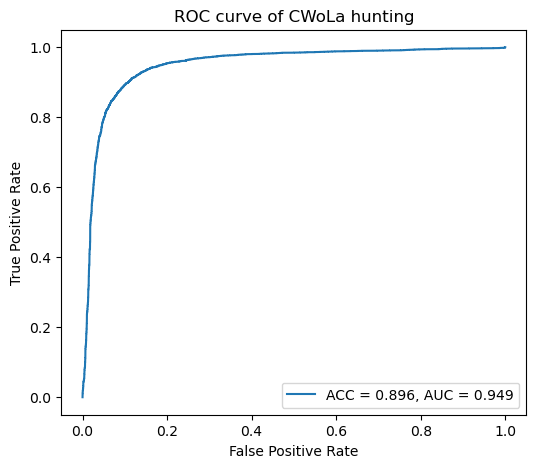

In [18]:
# Testing results on true label sample
d_col = [10,11,12,13,15]
true_label_path = f'./Sample/DNN/min_dR_1000GeV_test.npy'
X_test, y_test = load_samples(true_label_path, delete_col=d_col)

# Training results
loaded_model_name = f'./DNN/DNN_models/DNN_best_model_CWoLa_hunting_w_sig/'
loaded_model = tf.keras.models.load_model(loaded_model_name)
true_label_results = loaded_model.evaluate(x=X_test, y=y_test)

if true_label_results[1] < 0.5:
    y_test = y_test[:,[1,0]]
    true_label_results = loaded_model.evaluate(x=X_test, y=y_test)
print(f'True label: Testing Loss = {true_label_results[0]:.3}, Testing Accuracy = {true_label_results[1]:.3}')

# Compute AUC
labels = y_test
predictions = loaded_model.predict(X_test)

y_test = np.argmax(labels, axis=1)
y_prob = np.array(predictions)

i = 1
true_label_AUC = roc_auc_score(y_test==i,  y_prob[:,i])

fig, ax = plt.subplots(1, 1, figsize=(6,5))

fpr, tpr, thresholds = roc_curve(y_test==i, y_prob[:,i])
ax.plot(fpr, tpr, label = f'ACC = {true_label_results[1]:.3f}, AUC = {true_label_AUC:.3f}')

ax.set_title(f'ROC curve of CWoLa hunting')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

In [19]:
d_col = [10,11,12,13,15]

model_path = f'./DNN/DNN_models/DNN_best_model_CWoLa_hunting_w_sig/'
sample_path = f'./Sample/DNN/min_dR_1000GeV_test.npy'

y_label, y_pred_w_sig = get_signal_score(model_path, sample_path, d_col)

model_path = f'./DNN/DNN_models/DNN_best_model_CWoLa_hunting_wo_sig/'
sample_path = f'./Sample/DNN/min_dR_1000GeV_test.npy'

y_label, y_pred_wo_sig = get_signal_score(model_path, sample_path, d_col)

313/313 [==============================] - 1s 4ms/step - loss: 0.4743 - accuracy: 0.8962
True label: Testing Loss = 0.474, Testing Accuracy = 0.896
313/313 [==============================] - 1s 4ms/step - loss: 0.4822 - accuracy: 0.8939
True label: Testing Loss = 0.482, Testing Accuracy = 0.894
313/313 [==============================] - 0s 1ms/step


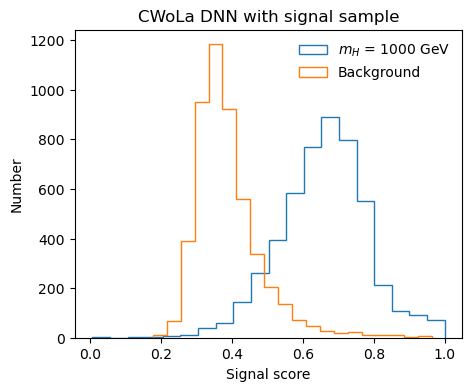

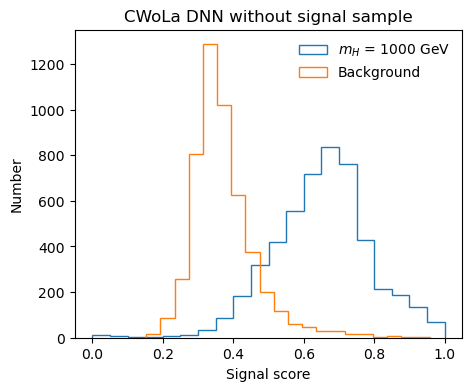

In [21]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

ax.hist(y_pred_w_sig[y_label==1], bins=20, histtype='step', label='$m_{H}$ = 1000 GeV')
ax.hist(y_pred_w_sig[y_label==0], bins=20, histtype='step', label='Background')
ax.legend(frameon=False)
ax.set_xlabel('Signal score')
ax.set_ylabel('Number')
ax.set_title('CWoLa DNN with signal sample')
plt.savefig('./figures/DNN_w_sig_signal_score_distribution-1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(5, 4))

ax.hist(y_pred_wo_sig[y_label==1], bins=20, histtype='step', label='$m_{H}$ = 1000 GeV')
ax.hist(y_pred_wo_sig[y_label==0], bins=20, histtype='step', label='Background')
ax.legend(frameon=False)
ax.set_xlabel('Signal score')
ax.set_ylabel('Number')
ax.set_title('CWoLa DNN without signal sample')
plt.savefig('./figures/DNN_wo_sig_signal_score_distribution-1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## 500 GeV

313/313 [==============================] - 1s 4ms/step - loss: 5.0509 - accuracy: 0.7028
True label: Testing Loss = 5.05, Testing Accuracy = 0.703
313/313 [==============================] - 1s 2ms/step


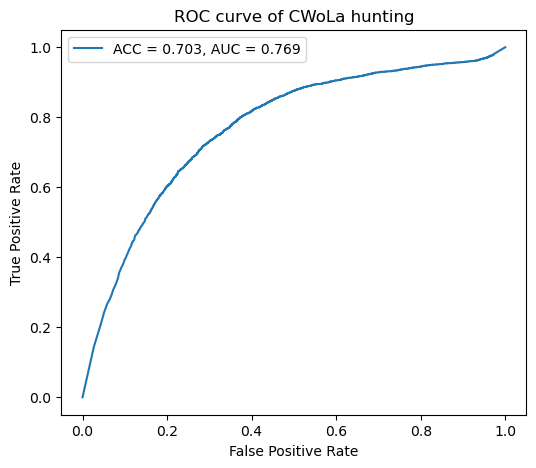

In [22]:
# Testing results on true label sample
d_col = [10,11,12,13,15]
true_label_path = f'./Sample/DNN/min_dR_500GeV_test.npy'
X_test, y_test = load_samples(true_label_path, delete_col=d_col)

# Training results
loaded_model_name = f'./DNN/DNN_models/DNN_best_model_CWoLa_hunting_w_sig_500GeV/'
loaded_model = tf.keras.models.load_model(loaded_model_name)
true_label_results = loaded_model.evaluate(x=X_test, y=y_test)

if true_label_results[1] < 0.5:
    y_test = y_test[:,[1,0]]
    true_label_results = loaded_model.evaluate(x=X_test, y=y_test)
print(f'True label: Testing Loss = {true_label_results[0]:.3}, Testing Accuracy = {true_label_results[1]:.3}')

# Compute AUC
labels = y_test
predictions = loaded_model.predict(X_test)

y_test = np.argmax(labels, axis=1)
y_prob = np.array(predictions)

i = 1
true_label_AUC = roc_auc_score(y_test==i,  y_prob[:,i])

fig, ax = plt.subplots(1, 1, figsize=(6,5))

fpr, tpr, thresholds = roc_curve(y_test==i, y_prob[:,i])
ax.plot(fpr, tpr, label = f'ACC = {true_label_results[1]:.3f}, AUC = {true_label_AUC:.3f}')

ax.set_title(f'ROC curve of CWoLa hunting')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# plt.savefig('./figures/ROC_CWoLa_hunting_1000GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

In [23]:
d_col = [10,11,12,13,15]

model_path = f'./DNN/DNN_models/DNN_best_model_CWoLa_hunting_w_sig_500GeV/'
sample_path = f'./Sample/DNN/min_dR_500GeV_test.npy'

y_label, y_pred_w_sig = get_signal_score(model_path, sample_path, d_col)

model_path = f'./DNN/DNN_models/DNN_best_model_CWoLa_hunting_wo_sig_500GeV/'
sample_path = f'./Sample/DNN/min_dR_500GeV_test.npy'

y_label, y_pred_wo_sig = get_signal_score(model_path, sample_path, d_col)

313/313 [==============================] - 1s 4ms/step - loss: 5.0509 - accuracy: 0.7028
True label: Testing Loss = 5.05, Testing Accuracy = 0.703
313/313 [==============================] - 1s 4ms/step - loss: 5.2253 - accuracy: 0.7045
True label: Testing Loss = 5.23, Testing Accuracy = 0.705
313/313 [==============================] - 1s 2ms/step


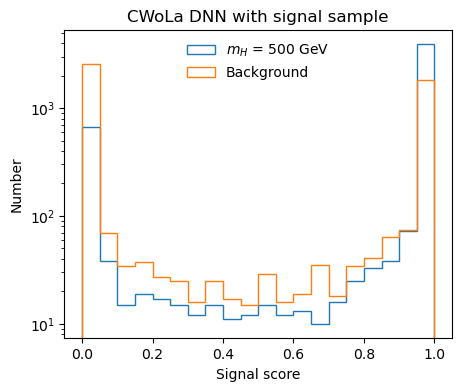

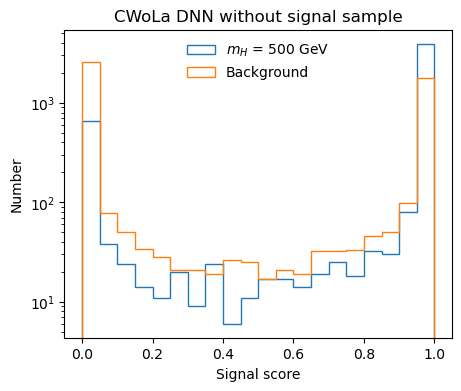

In [24]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

ax.hist(y_pred_w_sig[y_label==1], bins=20, histtype='step', label='$m_{H}$ = 500 GeV')
ax.hist(y_pred_w_sig[y_label==0], bins=20, histtype='step', label='Background')
ax.legend(frameon=False, loc='upper center')
ax.set_xlabel('Signal score')
ax.set_ylabel('Number')
ax.set_yscale('log')
ax.set_title('CWoLa DNN with signal sample')
plt.savefig('./figures/DNN_w_sig_signal_score_distribution-500GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(1,1,figsize=(5, 4))

ax.hist(y_pred_wo_sig[y_label==1], bins=20, histtype='step', label='$m_{H}$ = 500 GeV')
ax.hist(y_pred_wo_sig[y_label==0], bins=20, histtype='step', label='Background')
ax.legend(frameon=False, loc='upper center')
ax.set_xlabel('Signal score')
ax.set_ylabel('Number')
ax.set_yscale('log')
ax.set_title('CWoLa DNN without signal sample')
plt.savefig('./figures/DNN_wo_sig_signal_score_distribution-500GeV.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Summary

In [25]:
file_name = './DNN/CWoLa_Hunting_training_results.csv'
df = pd.read_csv(file_name)

## 1000 GeV

In [26]:
print('With signal sample')
mu = df[df['Sample Type'] == 'With signal']['ACC-true'].mean()
sigma = df[df['Sample Type'] == 'With signal']['ACC-true'].std()
best = df[df['Sample Type'] == 'With signal']['ACC-true'].max()
print(f'ACC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

mu = df[df['Sample Type'] == 'With signal']['AUC-true'].mean()
sigma = df[df['Sample Type'] == 'With signal']['AUC-true'].std()
best = df[df['Sample Type'] == 'With signal']['AUC-true'].max()
print(f'AUC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')


print('No signal sample')
mu = df[df['Sample Type'] == 'No signal']['ACC-true'].mean()
sigma = df[df['Sample Type'] == 'No signal']['ACC-true'].std()
best = df[df['Sample Type'] == 'No signal']['ACC-true'].max()
print(f'ACC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

mu = df[df['Sample Type'] == 'No signal']['AUC-true'].mean()
sigma = df[df['Sample Type'] == 'No signal']['AUC-true'].std()
best = df[df['Sample Type'] == 'No signal']['AUC-true'].max()
print(f'AUC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

With signal sample
ACC: 0.868 +- 0.024, Best: 0.896
AUC: 0.925 +- 0.023, Best: 0.951
No signal sample
ACC: 0.850 +- 0.033, Best: 0.897
AUC: 0.909 +- 0.026, Best: 0.949


## 500 GeV

In [27]:
print('With signal sample')
mu = df[df['Sample Type'] == '500 GeV: With signal']['ACC-true'].mean()
sigma = df[df['Sample Type'] == '500 GeV: With signal']['ACC-true'].std()
best = df[df['Sample Type'] == '500 GeV: With signal']['ACC-true'].max()
print(f'ACC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

mu = df[df['Sample Type'] == '500 GeV: With signal']['AUC-true'].mean()
sigma = df[df['Sample Type'] == '500 GeV: With signal']['AUC-true'].std()
best = df[df['Sample Type'] == '500 GeV: With signal']['AUC-true'].max()
print(f'AUC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')


print('No signal sample')
mu = df[df['Sample Type'] == '500 GeV: No signal']['ACC-true'].mean()
sigma = df[df['Sample Type'] == '500 GeV: No signal']['ACC-true'].std()
best = df[df['Sample Type'] == '500 GeV: No signal']['ACC-true'].max()
print(f'ACC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

mu = df[df['Sample Type'] == '500 GeV: No signal']['AUC-true'].mean()
sigma = df[df['Sample Type'] == '500 GeV: No signal']['AUC-true'].std()
best = df[df['Sample Type'] == '500 GeV: No signal']['AUC-true'].max()
print(f'AUC: {mu:.3f} +- {sigma:.3f}, Best: {best:.3f}')

With signal sample
ACC: 0.708 +- 0.002, Best: 0.711
AUC: 0.770 +- 0.007, Best: 0.786
No signal sample
ACC: 0.705 +- 0.003, Best: 0.709
AUC: 0.769 +- 0.009, Best: 0.783


## Thresholds

In [27]:
def get_threshold_from_pass_rate(passing_rate, fpr, tpr, thresholds):
    n_th = ((fpr + tpr) < passing_rate * 2).sum()
    print(n_th)
    return thresholds[n_th]

In [28]:
th_010 = get_threshold_from_pass_rate(0.10, fpr, tpr, thresholds)
th_001 = get_threshold_from_pass_rate(0.01, fpr, tpr, thresholds)
th_0001 = get_threshold_from_pass_rate(0.001, fpr, tpr, thresholds)

print(th_010, th_001, th_0001)

92
8
2
0.7565069 0.9385723 0.9672062


# CWoLa selection

In [29]:
def diHiggs_selection_npy(file_path, tot_event, cross_section, th):
    # 輸入檔案為已配對的.npy檔
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選

    X, _ = load_samples(file_path)
    X_test, _ = load_samples(file_path, delete_col=[10,11,12,13,15])
    nevent = X.shape[0]
    Eta_PT_BTag_count = X.shape[0]

    # Model
    model_path = f'./DNN/DNN_models/DNN_last_model_CWoLa_hunting_w_sig/'
    loaded_model = tf.keras.models.load_model(model_path)

    predictions = loaded_model.predict(X_test)[:,1]

    mhh = X[:,15]
    mhh_DNN = X[:,15][predictions > th]

    SR_range = [800, 1050]
    SB_range = [700, 1100]

    predictions_SR = predictions[(SR_range[0] < mhh) & (mhh < SR_range[1])]

    SR_count = predictions_SR.shape[0]
    DNN_count = (predictions_SR > th).sum()
    
    
    # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
    cross_section_abs = cross_section * X.shape[0] / tot_event
    
    cutflow_count = {
        'nevent': tot_event,
        'Cross section': cross_section,
        'Four tag': Eta_PT_BTag_count,
        'Signal region': SR_count,
        'DNN selection': DNN_count,
        # 'Sideband region': SB_count,
    }
        
    cutflow_cross_section = {
        'nevent': nevent,
        'Cross section': cross_section,
        'Four tag': cross_section_abs,
        'Signal region': cross_section_abs * SR_count / nevent,
        'DNN selection': cross_section_abs * DNN_count / nevent,
        # 'Sideband region': cross_section_abs * SB_count / nevent,
    }
    
    results = {
        'cutflow count': cutflow_count,
        'cutflow cross section':cutflow_cross_section,
        'mhh': mhh,
        'DNN selected mhh': mhh_DNN,
    }
    
    return results

In [30]:
sample_path = f'../CPVDM/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/h5_data/min_dR_high_level.npy'
run_path = '/home/r10222035/CPVDM/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/run_01'
h5_path = '/home/r10222035/CPVDM/THDM-testing/Parameter_Scanning/MG5/proc_ppHhh_1000GeV/Events/h5_data/DiHiggs_4b_PT40.h5'

xection, tot_event = get_info(run_path)
results_s = diHiggs_selection_npy(sample_path,
                      tot_event,
                      xection,
                      th_010,
                      )

383/383 [==============================] - 1s 2ms/step


In [31]:
sample_path = f'./Sample/DNN/min_dR_high_level_bkg.npy'
run_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/MG5/resonant/pp4b_2525/Events/run_01'
h5_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/resonant/pp4b_2525/1M_diHiggs_4b_PT40-01.h5'

xection, tot_event = get_info(run_path)
results_b = diHiggs_selection_npy(sample_path,
                      tot_event,
                      xection,
                      th_010,
                      )

300/300 [==============================] - 0s 1ms/step


In [32]:
print(results_s['cutflow count'])
print(results_b['cutflow count'])

{'nevent': 100000, 'Cross section': 0.66007, 'Four tag': 12234, 'Signal region': 9561, 'DNN selection': 1517}
{'nevent': 1000000, 'Cross section': 630389.756, 'Four tag': 9571, 'Signal region': 527, 'DNN selection': 25}


In [33]:
L = 139
ns = results_s['cutflow cross section']['Signal region'] * L
nb = results_b['cutflow cross section']['Signal region'] * L

print(f'S/B: {ns/nb:.2e}, S/sqrt(B): {ns/nb**0.5:.4f}')

ns = results_s['cutflow cross section']['DNN selection'] * L
nb = results_b['cutflow cross section']['DNN selection'] * L

print(f'S/B: {ns/nb:.2e}, S/sqrt(B): {ns/nb**0.5:.4f}')

S/B: 1.90e-04, S/sqrt(B): 0.0408
S/B: 6.35e-04, S/sqrt(B): 0.0297


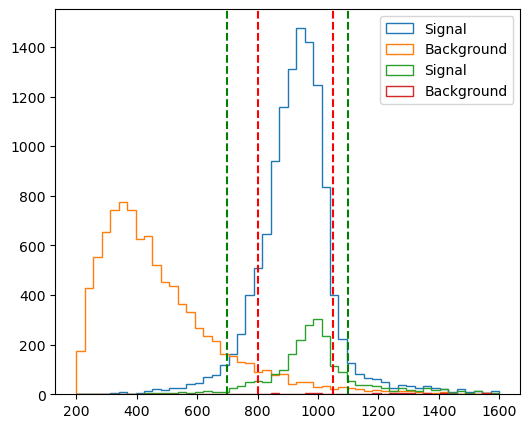

In [34]:
fig, ax = plt.subplots(1,1,figsize=(6, 5))

ax.hist(results_s['mhh'], range=(200,1600), bins=50, histtype='step', density=False, label='Signal')
ax.hist(results_b['mhh'], range=(200,1600), bins=50, histtype='step', density=False, label='Background')

ax.hist(results_s['DNN selected mhh'], range=(200,1600), bins=50, histtype='step', density=False, label='Signal')
ax.hist(results_b['DNN selected mhh'], range=(200,1600), bins=50, histtype='step', density=False, label='Background')

# 指定要繪製垂直線的x座標
x_SR = [800,1050]
x_SB = [700,1100]
# 使用axvline函數繪製垂直線
ax.axvline(x=x_SR[0], color='r', linestyle='--')
ax.axvline(x=x_SR[1], color='r', linestyle='--')

ax.axvline(x=x_SB[0], color='g', linestyle='--')
ax.axvline(x=x_SB[1], color='g', linestyle='--')

ax.legend()
plt.show()